# Optimizing IT Support Team Performance Using Analytics
## Milestone 1: Data Preparation & Feature Engineering

This notebook documents the steps involved in loading, cleaning, and preparing customer support ticket data for performance analysis.



###Module 1: Project Initialization and Dataset Setup

In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Clsutering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


## Dataset Overview

The dataset used in this project contains real-world customer support ticket records including ticket priority, response time, resolution time, and customer satisfaction ratings.


In [2]:
df = pd.read_csv("/content/customer_support_tickets.csv")
df.head()


,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,22-03-2021,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,01-06-2023 12:15,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,22-05-2021,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,01-06-2023 16:45,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,14-07-2020,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,01-06-2023 11:14,01-06-2023 18:05,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,13-11-2020,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,01-06-2023 07:29,01-06-2023 01:57,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,04-02-2020,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,01-06-2023 00:12,01-06-2023 19:53,1.0


In [3]:
df.shape
df.info()
df.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')

###Module 2: Data Cleaning and Feature Engineering

In [4]:
df.isnull().sum()


,0
Ticket ID,0
Customer Name,0
Customer Email,0
Customer Age,0
Customer Gender,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0


In [5]:
df['Ticket Priority'].value_counts()
df['Ticket Status'].value_counts()
df['Ticket Type'].value_counts()


,count
Ticket Type,
Refund request,1752
Technical issue,1747
Cancellation request,1695
Product inquiry,1641
Billing inquiry,1634


In [6]:
df = df.drop(columns=[
    'Customer Name',
    'Customer Email',
    'Customer Age',
    'Customer Gender'
])


## Datetime Processing

Timestamp columns are converted into datetime format to enable accurate calculation of resolution duration and other time-based performance metrics.


In [7]:
df['Time to Resolution'] = pd.to_datetime(
    df['Time to Resolution'],
    errors='coerce'
)

df['First Response Time'] = pd.to_datetime(
    df['First Response Time'],
    errors='coerce'
)

df[['First Response Time', 'Time to Resolution']].dtypes

df['Resolution_Duration_Hours'] = (
    df['Time to Resolution'] - df['First Response Time']
).dt.total_seconds() / 3600

df['Resolution_Duration_Hours'] = df['Resolution_Duration_Hours'].fillna(
    df['Resolution_Duration_Hours'].median()
)


In [8]:
df['First_Response_Duration_Hours'] = (
    df['First Response Time'] - df['First Response Time'].min()
).dt.total_seconds() / 3600

df['Resolution_Efficiency'] = (
    df['Resolution_Duration_Hours'] / df['First_Response_Duration_Hours']
)

df['Resolution_Efficiency'] = df['Resolution_Efficiency'].replace(
    [np.inf, -np.inf], np.nan
)

df['Resolution_Efficiency'] = df['Resolution_Efficiency'].fillna(
    df['Resolution_Efficiency'].median()
)


In [9]:
priority_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Critical': 4
}

df['Priority_Score'] = df['Ticket Priority'].map(priority_map)


In [10]:
df.isnull().sum()


,0
Ticket ID,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0
Ticket Status,0
Resolution,5700
Ticket Priority,0
Ticket Channel,0


## Feature Engineering and Final Output

New performance-related features such as resolution duration, resolution efficiency, and priority score were engineered. The cleaned dataset is saved for use in subsequent milestones.


In [11]:
df.to_csv("/content/cleaned_customer_support_tickets.csv", index=False)


# Milestone 2: Exploratory Visualization & Cluster Insights


## Module 3: Exploratory Visualization


In [12]:
df = pd.read_csv("/content/cleaned_customer_support_tickets.csv")

In [13]:
df.columns


Index(['Ticket ID', 'Product Purchased', 'Date of Purchase', 'Ticket Type',
       'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution',
       'Ticket Priority', 'Ticket Channel', 'First Response Time',
       'Time to Resolution', 'Customer Satisfaction Rating',
       'Resolution_Duration_Hours', 'First_Response_Duration_Hours',
       'Resolution_Efficiency', 'Priority_Score'],
      dtype='object')

PLOT 1: Ticket Type Distribution



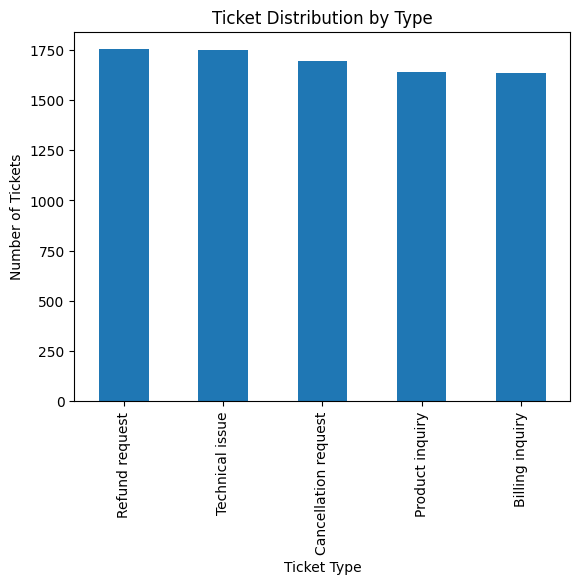

In [14]:
plt.figure()
df['Ticket Type'].value_counts().plot(kind='bar')
plt.title("Ticket Distribution by Type")
plt.xlabel("Ticket Type")
plt.ylabel("Number of Tickets")
plt.show()


PLOT 2: Ticket Priority Distribution





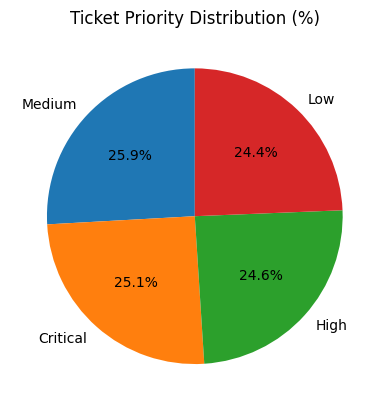

In [15]:
plt.figure()
df['Ticket Priority'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Ticket Priority Distribution (%)")
plt.ylabel("")
plt.show()



PLOT 3: Ticket Status Distribution

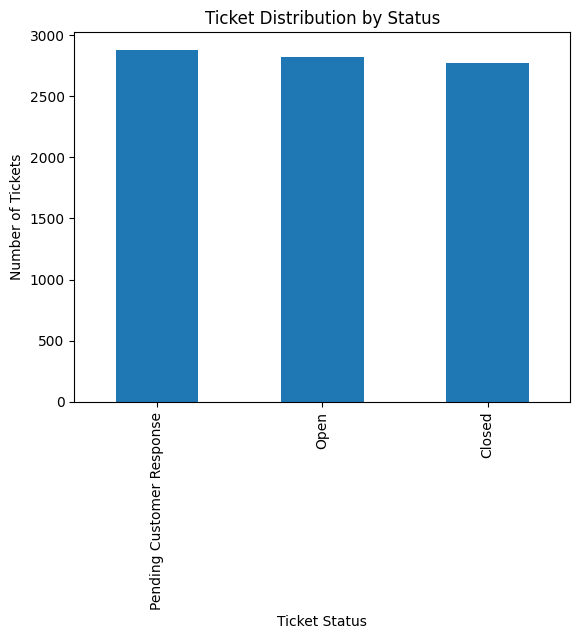

In [16]:
plt.figure()
df['Ticket Status'].value_counts().plot(kind='bar')
plt.title("Ticket Distribution by Status")
plt.xlabel("Ticket Status")
plt.ylabel("Number of Tickets")
plt.show()


PLOT 4: Ticket Channel Distribution

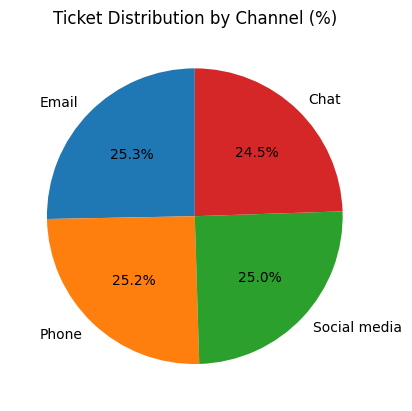

In [17]:
plt.figure()
df['Ticket Channel'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Ticket Distribution by Channel (%)")
plt.ylabel("")
plt.show()


PLOT 5: Top 10 Ticket Subjects

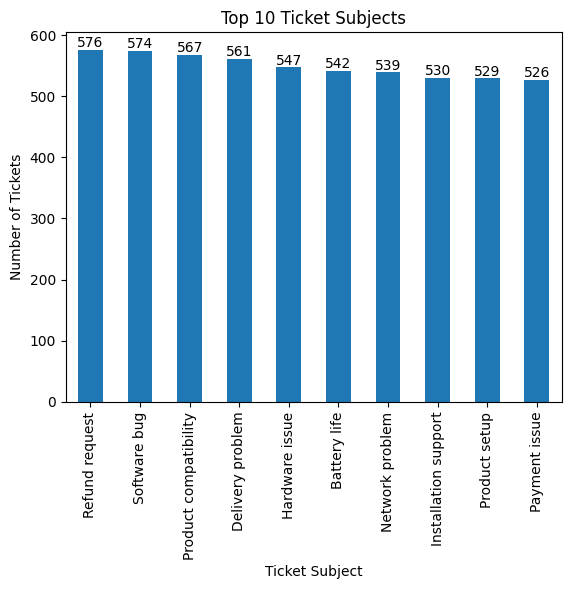

In [18]:
plt.figure()
ax = df['Ticket Subject'].value_counts().head(10).plot(kind='bar')

plt.title("Top 10 Ticket Subjects")
plt.xlabel("Ticket Subject")
plt.ylabel("Number of Tickets")

ax.bar_label(ax.containers[0])

plt.show()


PLOT 6: Resolution Duration Distribution

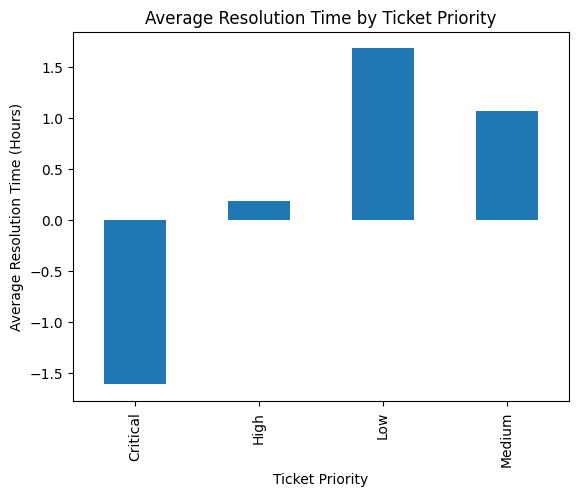

In [19]:
plt.figure()

avg_resolution = df.groupby('Ticket Priority')['Resolution_Duration_Hours'].mean()

avg_resolution.plot(kind='bar')

plt.title("Average Resolution Time by Ticket Priority")
plt.xlabel("Ticket Priority")
plt.ylabel("Average Resolution Time (Hours)")

plt.show()


PLOT 7: Customer Satisfaction Rating Distribution

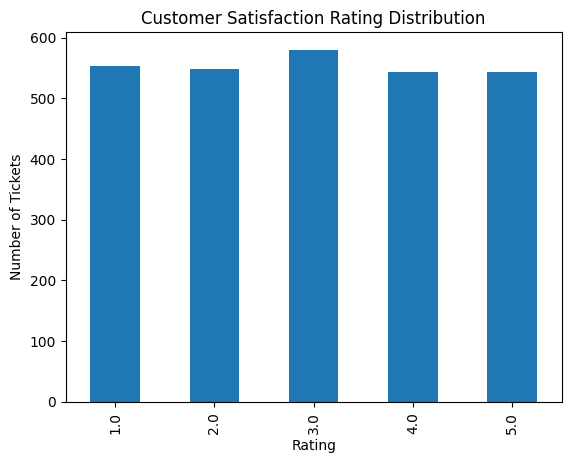

In [20]:
plt.figure()
df['Customer Satisfaction Rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Customer Satisfaction Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Tickets")
plt.show()


#Ticket Resolution Status

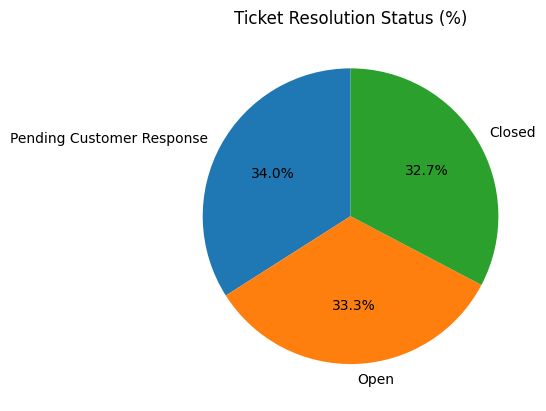

In [21]:
plt.figure()

df['Ticket Status'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90
)

plt.title("Ticket Resolution Status (%)")
plt.ylabel("")
plt.show()


#Top Categories and Clusters by Frequency

Get top categories

In [22]:
top_categories = df['Ticket Subject'].value_counts().head(10)
top_categories


,count
Ticket Subject,
Refund request,576
Software bug,574
Product compatibility,567
Delivery problem,561
Hardware issue,547
Battery life,542
Network problem,539
Installation support,530
Product setup,529


Bar graph WITH exact numbers

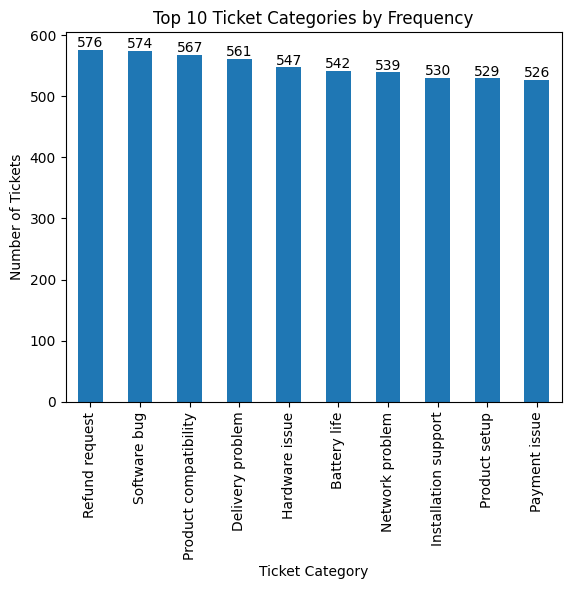

In [23]:
plt.figure()

ax = top_categories.plot(kind='bar')

plt.title("Top 10 Ticket Categories by Frequency")
plt.xlabel("Ticket Category")
plt.ylabel("Number of Tickets")

ax.bar_label(ax.containers[0])

plt.show()


#Visualizing Ticket by Priority and Channel

Verifying Columns

In [24]:
df[['Ticket Priority', 'Ticket Channel']].head()


,Ticket Priority,Ticket Channel
0,Critical,Social media
1,Critical,Chat
2,Low,Social media
3,Low,Social media
4,Low,Email


Plotting Ticket Priority vs Ticket Channel

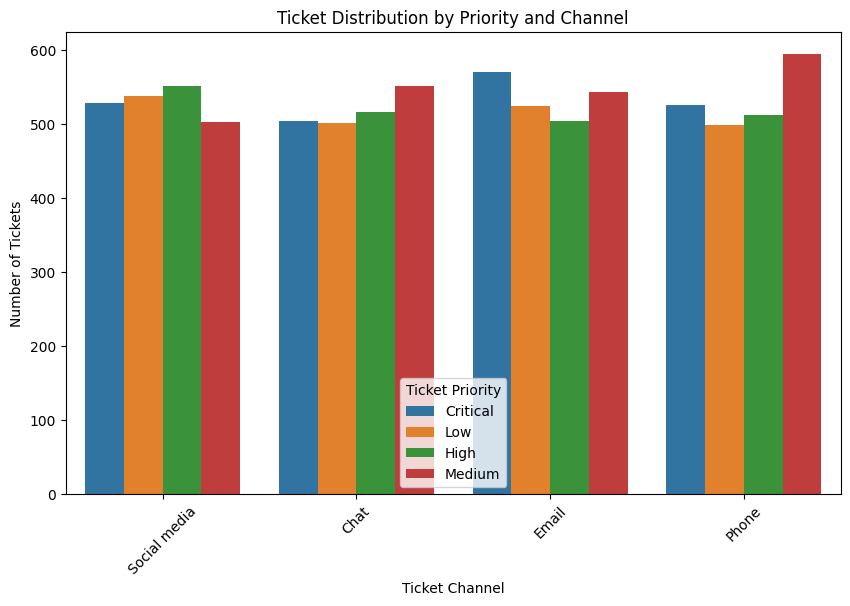

In [25]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=df,
    x='Ticket Channel',
    hue='Ticket Priority'
)

plt.title("Ticket Distribution by Priority and Channel")
plt.xlabel("Ticket Channel")
plt.ylabel("Number of Tickets")
plt.xticks(rotation=45)
plt.legend(title="Ticket Priority")

plt.show()


#Combining Ticket Subject + Description

In [26]:
df['Ticket_text'] = (
    df['Ticket Subject'].fillna('')+' '+
    df['Ticket Description'].fillna('')
)

Converting Text to Numbers

In [27]:
vectorizer = TfidfVectorizer(
    stop_words = 'english',
    max_features=500
)

X = vectorizer.fit_transform(df['Ticket_text'])

Create Clusters (Using KMeans)

In [28]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
df['Cluster_ID'] = kmeans.fit_predict(X)

In [29]:
df['Cluster_ID'].value_counts()


,count
Cluster_ID,
3,3587
1,2338
2,956
4,932
0,656


Identifying Top Clusters By Frequency

In [30]:
cluster_counts = df['Cluster_ID'].value_counts().sort_index()
cluster_counts


,count
Cluster_ID,
0,656
1,2338
2,956
3,3587
4,932


Visuals Top Cluster By Frquency

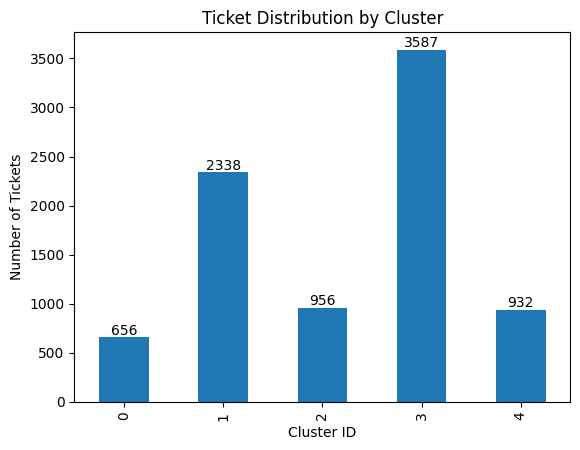

In [31]:
plt.figure()

ax = cluster_counts.plot(kind='bar')
plt.title("Ticket Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tickets")

ax.bar_label(ax.containers[0])
plt.show()


WHAT EACH CLUSTER REPRESENTS

In [32]:
df.groupby('Cluster_ID')['Ticket Subject'].head(3)


,Ticket Subject
0,Product setup
1,Peripheral compatibility
2,Network problem
3,Account access
4,Data loss
5,Payment issue
6,Refund request
7,Battery life
8,Installation support
9,Payment issue


Computing Similarity Scores

In [33]:
centroids = kmeans.cluster_centers_

similarity_matrix = cosine_similarity(X, centroids)

df['Similarity_Score'] = [
    similarity_matrix[i, cluster]
    for i, cluster in enumerate(df['Cluster_ID'])
]


#Analyze Similarity Scores within Clusters

Calculating Average Similarity

In [34]:
avg_similarity = df.groupby('Cluster_ID')['Similarity_Score'].mean()
avg_similarity


,Similarity_Score
Cluster_ID,
0,0.464732
1,0.369989
2,0.457770
3,0.318944
4,0.527199


Visuals of Average Similarity Scores

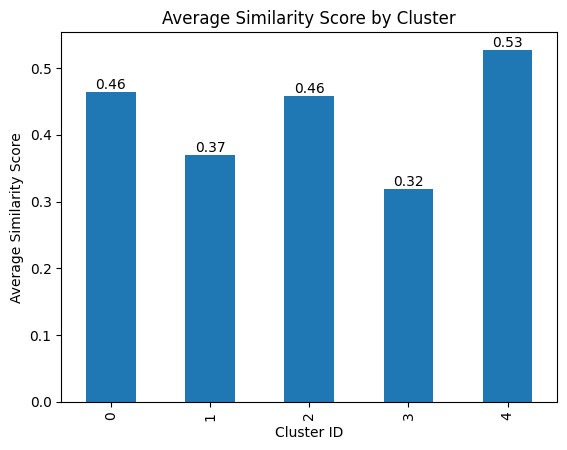

In [35]:
plt.figure()

ax = avg_similarity.plot(kind='bar')

plt.title("Average Similarity Score by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Average Similarity Score")

ax.bar_label(ax.containers[0], fmt="%.2f")
plt.show()


Average Resolution Time by Cluster

In [36]:
avg_resolution_cluster = df.groupby('Cluster_ID')['Resolution_Duration_Hours'].mean()
avg_resolution_cluster


,Resolution_Duration_Hours
Cluster_ID,
0,3.242683
1,-0.836477
2,1.237483
3,0.151617
4,0.892686


Visuals of Average Time Resolution by Cluster

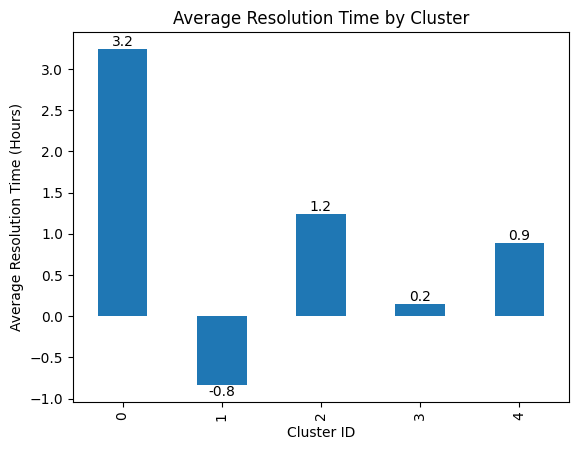

In [37]:
plt.figure()

ax = avg_resolution_cluster.plot(kind='bar')
plt.title("Average Resolution Time by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Average Resolution Time (Hours)")

ax.bar_label(ax.containers[0], fmt="%.1f")
plt.show()


#Compare Cluster Size VS. Issue Type

In [38]:
#Dfeining "Issue Type": The best Issue type is 'Ticket Subject' according to my dataset

Creating a Cluster and Issue Type Table

In [39]:
cluster_issue_counts = (
    df.groupby(['Cluster_ID', 'Ticket Subject']).size()
    .reset_index(name = 'Ticket_Count')
)

cluster_issue_counts.head()

,Cluster_ID,Ticket Subject,Ticket_Count
0,0,Account access,41
1,0,Battery life,40
2,0,Cancellation request,44
3,0,Data loss,43
4,0,Delivery problem,45


Identifying Top Isuue per Cluster

In [40]:
top_issue_per_cluster = (
    cluster_issue_counts.sort_values(['Cluster_ID', 'Ticket_Count'], ascending = [True, False])
    .groupby('Cluster_ID').head(1)
)

top_issue_per_cluster

,Cluster_ID,Ticket Subject,Ticket_Count
15,0,Software bug,49
29,1,Product setup,174
36,2,Delivery problem,72
62,3,Refund request,253
70,4,Hardware issue,76


Visuals of Cluster Size VS. Issue Type

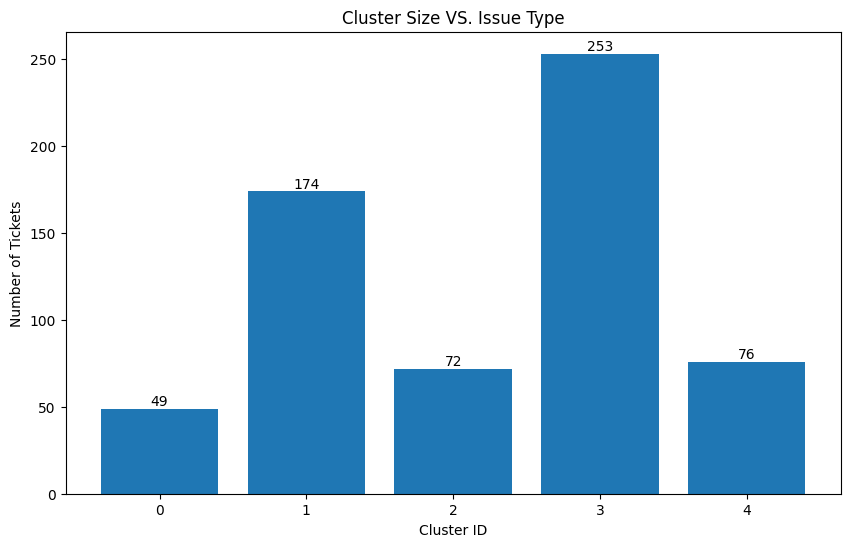

In [41]:
plt.figure(figsize = (10,6))

ax = plt.bar(
    top_issue_per_cluster['Cluster_ID'].astype(str),
    top_issue_per_cluster['Ticket_Count']
)

plt.title("Cluster Size VS. Issue Type")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Tickets")

plt.bar_label(ax)

plt.show()

#Visualize performance gaps using boxplots and scatter plots

Plot 1 (Boxplot) : Resolution Time by Cluster

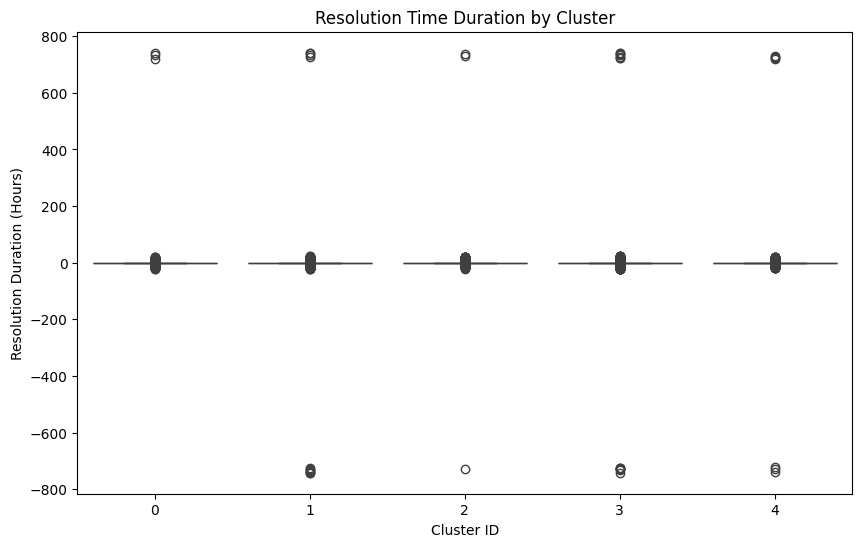

In [42]:
plt.figure(figsize=(10,6))

sns.boxplot(
    x = 'Cluster_ID',
    y = 'Resolution_Duration_Hours',
    data = df
)

plt.title("Resolution Time Duration by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Resolution Duration (Hours)")
plt.show()

Plot 2 (Boxplot): Customer Satisfaction Distribution by Cluster

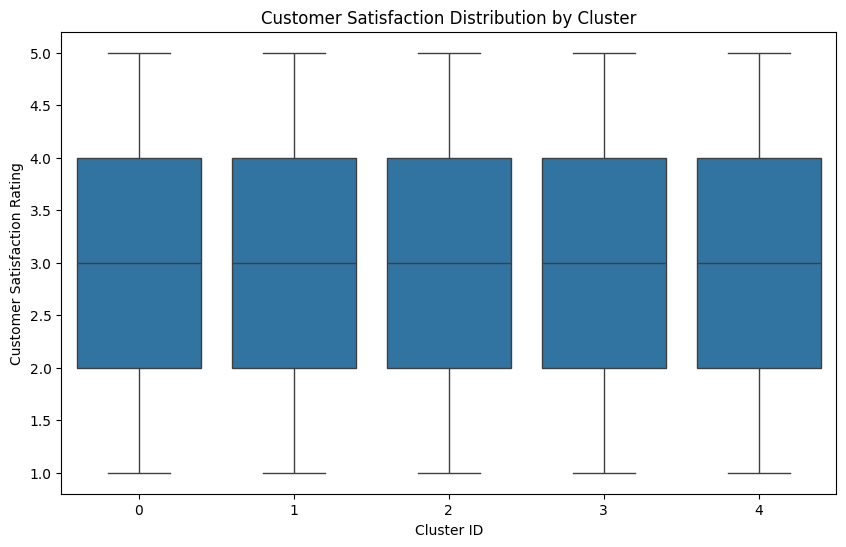

In [43]:
plt.figure(figsize = (10,6))

sns.boxplot(
    x = 'Cluster_ID',
    y = 'Customer Satisfaction Rating',
    data = df
)

plt.title("Customer Satisfaction Distribution by Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Customer Satisfaction Rating")
plt.show()

Plot 3 (Scatter Plot): Similarity Score VS. Resolution Time

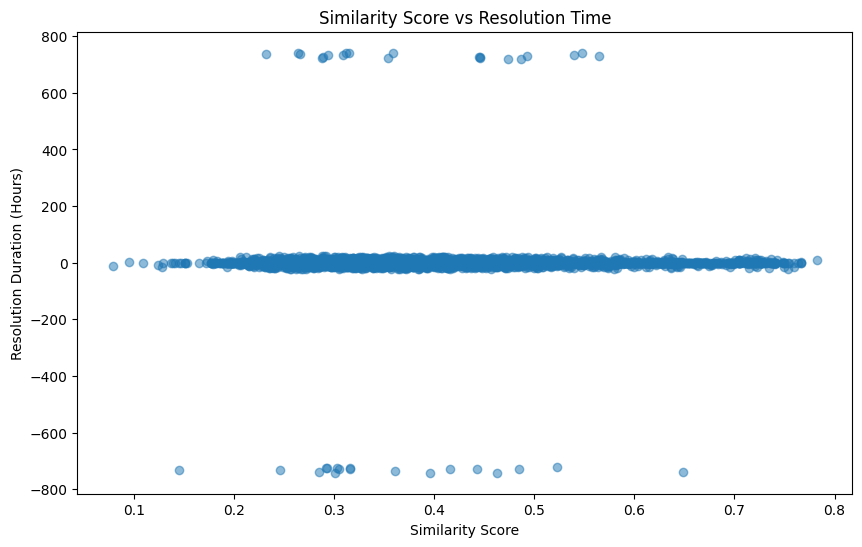

In [44]:
plt.figure(figsize = (10,6))

plt.scatter(
    df['Similarity_Score'],
    df['Resolution_Duration_Hours'],
    alpha = 0.5
)

plt.title("Similarity Score vs Resolution Time")
plt.xlabel("Similarity Score")
plt.ylabel("Resolution Duration (Hours)")
plt.show()

Plot 4 (Scatter Plot): Resolution Time VS. Customer Satisfaction

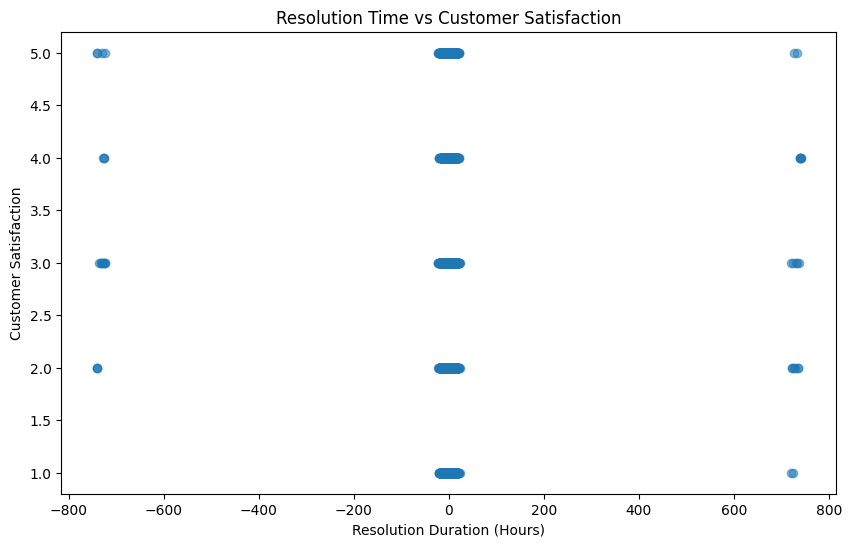

In [45]:
plt.figure(figsize = (10,6))

plt.scatter(
    df['Resolution_Duration_Hours'],
    df['Customer Satisfaction Rating'],
    alpha = 0.5
)

plt.title("Resolution Time vs Customer Satisfaction")
plt.xlabel("Resolution Duration (Hours)")
plt.ylabel("Customer Satisfaction")
plt.show()

#Milestone 3: Performance Trend Analysis / Geographic and Category-Level Insights

#Module 5: Performance Trend Analysis

Creating New Column for Resolution Time

In [46]:
# I already have a column called Resolution_Duration_Hours (from Milestone 1).
# Reusing that column.

df['Resolution_Time'] = df['Resolution_Duration_Hours']
df['Resolution_Time'].head(5)

,Resolution_Time
0,0.216667
1,0.216667
2,6.850000
3,-5.533333
4,19.683333


Calculating Average Resolution Time (For Entire Dataset)

In [47]:
avg_resolution_time_overall = df['Resolution_Time'].mean()
avg_resolution_time_overall

np.float64(0.3223973708033223)

Plot 1(Bar Chart): Average Resolution Time(For entire Dataset)

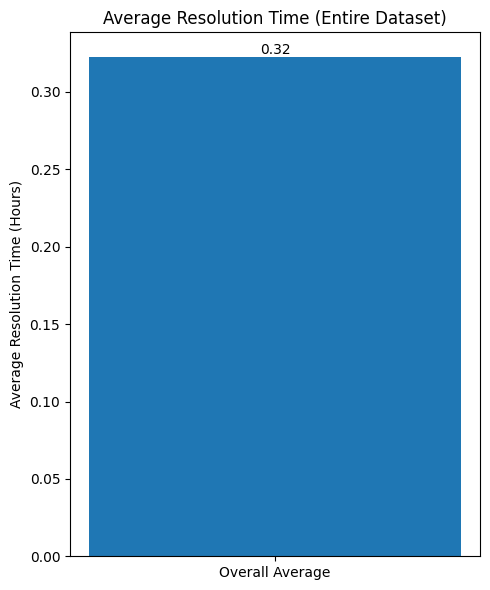

In [48]:
plt.figure(figsize=(5,6))

# Create a single bar
bars = plt.bar(
    ['Overall Average'],
    [avg_resolution_time_overall]
)

plt.title('Average Resolution Time (Entire Dataset)')
plt.ylabel('Average Resolution Time (Hours)')

plt.bar_label(bars, fmt="%.2f")

plt.tight_layout()
plt.show()


Calculating Average Resolution Time (For each Ticket Type)


In [49]:
avg_resolution_by_type = (
    df.groupby('Ticket Type')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_resolution_by_type


,Resolution_Time
Ticket Type,
Technical issue,2.198865
Refund request,1.416705
Cancellation request,0.161583
Billing inquiry,-0.786720
Product inquiry,-1.573116


Plot 2(Bar Chart): Average Resolution Time (For each Ticket Type)

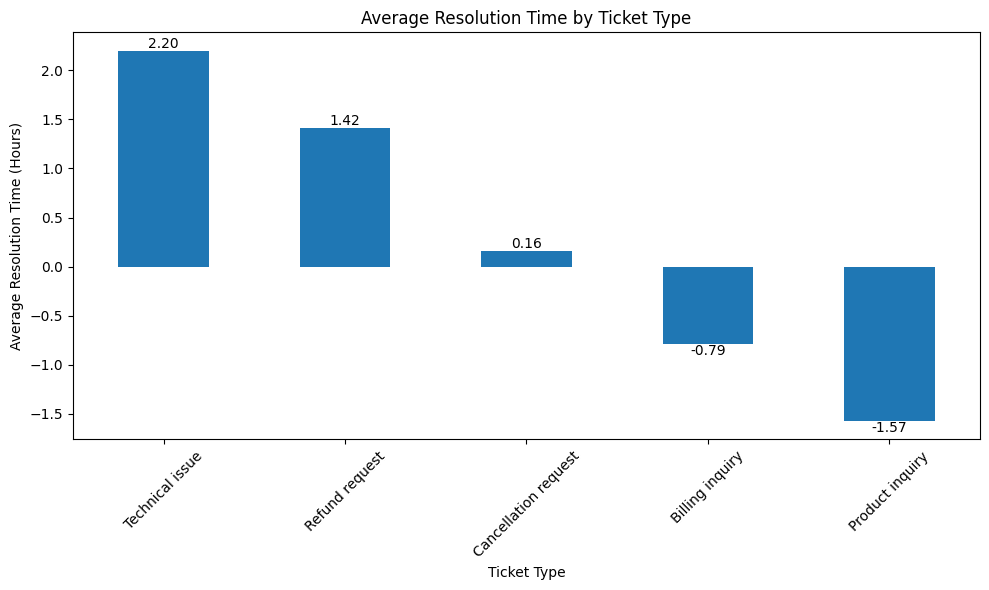

In [50]:
plt.figure(figsize=(10,6))
ax = avg_resolution_by_type.plot(kind='bar')

plt.title("Average Resolution Time by Ticket Type")
plt.xlabel("Ticket Type")
plt.ylabel("Average Resolution Time (Hours)")
plt.xticks(rotation=45)

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()



Calculating Average Resolution Time By Priority

In [51]:
avg_resolution_by_priority = (
    df.groupby('Ticket Priority')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_resolution_by_priority


,Resolution_Time
Ticket Priority,
Low,1.677266
Medium,1.064355
High,0.179305
Critical,-1.614248


Plot 3(Bar Chart): Priority vs Average Resolution Time

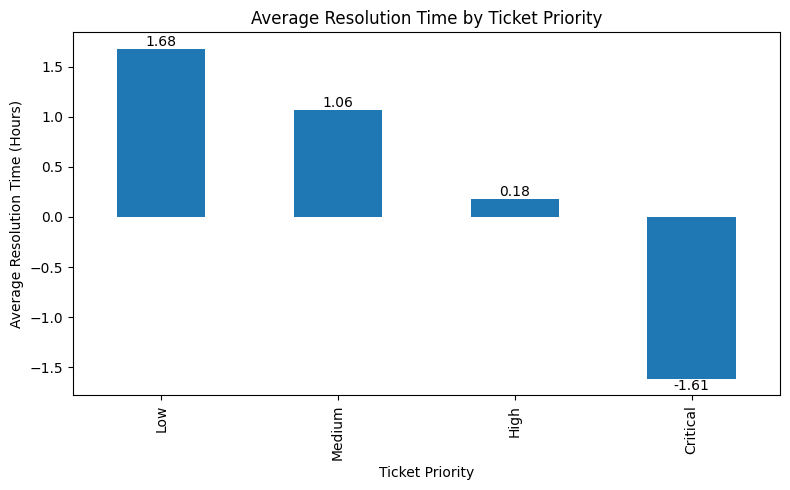

In [52]:
plt.figure(figsize=(8,5))

ax = avg_resolution_by_priority.plot(kind='bar')

plt.title('Average Resolution Time by Ticket Priority')
plt.xlabel('Ticket Priority')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


Calculating Resolution Time by Ticket Type

In [53]:
avg_resolution_by_type = (
    df.groupby('Ticket Type')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_resolution_by_type


,Resolution_Time
Ticket Type,
Technical issue,2.198865
Refund request,1.416705
Cancellation request,0.161583
Billing inquiry,-0.786720
Product inquiry,-1.573116


Plot 4(Box Plot): Ticket Type vs Resolution Time

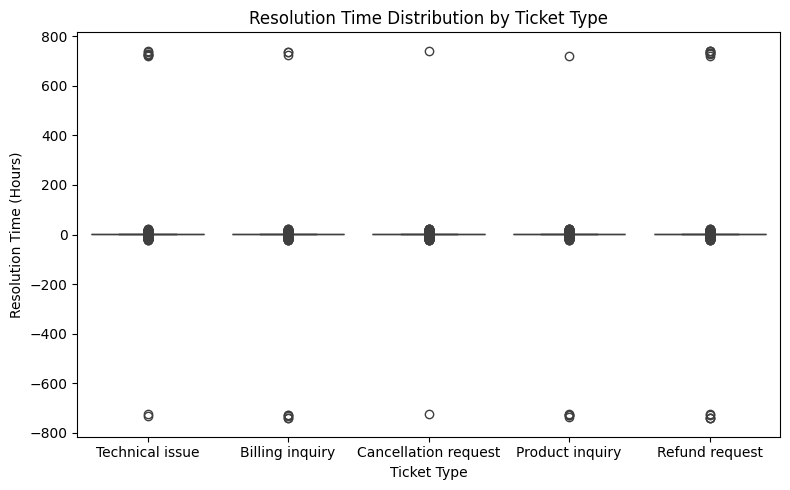

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x='Ticket Type',
    y='Resolution_Time'
)

plt.title('Resolution Time Distribution by Ticket Type')
plt.xlabel('Ticket Type')
plt.ylabel('Resolution Time (Hours)')

plt.tight_layout()
plt.show()


Analyze High Priority Tickets by Ticket Type

In [55]:
high_priority_df = df[df['Ticket Priority'] == 'High']

high_priority_df.head(5)

,Ticket ID,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,...,Time to Resolution,Customer Satisfaction Rating,Resolution_Duration_Hours,First_Response_Duration_Hours,Resolution_Efficiency,Priority_Score,Ticket_text,Cluster_ID,Similarity_Score,Resolution_Time
10,11,Nintendo Switch,19-01-2021,Cancellation request,Data loss,I'm having an issue with the {product_purchase...,Closed,Measure tonight surface feel forward.,High,Phone,...,NaN,1.0,0.216667,17.766667,0.012195,3,Data loss I'm having an issue with the {produc...,3,0.282208,0.216667
11,12,Microsoft Xbox Controller,24-10-2021,Product inquiry,Software bug,I'm having an issue with the {product_purchase...,Closed,Measure there house management pick knowledge ...,High,Chat,...,2023-01-06 09:27:00,1.0,-2.633333,12.083333,-0.217931,3,Software bug I'm having an issue with the {pro...,1,0.415350,-2.633333
14,15,Sony PlayStation,29-02-2020,Billing inquiry,Product setup,I'm having an issue with the {product_purchase...,Closed,Officer moment world sing parent available.,High,Chat,...,NaN,4.0,0.216667,6.366667,0.034031,3,Product setup I'm having an issue with the {pr...,4,0.658040,0.216667
15,16,GoPro Action Camera,24-06-2021,Billing inquiry,Product recommendation,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Social media,...,NaN,NaN,0.216667,15.150000,0.014301,3,Product recommendation I'm having an issue wit...,3,0.291734,0.216667
17,18,Microsoft Xbox Controller,07-09-2020,Product inquiry,Payment issue,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Chat,...,NaN,NaN,0.216667,21.083333,0.010277,3,Payment issue I'm having an issue with the {pr...,1,0.425216,0.216667


Compare Resolution Time for
High-Priority Requests vs Incidents vs Problems

In [56]:
avg_high_priority_by_type = (
    high_priority_df
    .groupby('Ticket Type')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_high_priority_by_type


,Resolution_Time
Ticket Type,
Technical issue,3.376055
Refund request,2.048661
Cancellation request,0.277094
Billing inquiry,-2.274695
Product inquiry,-3.337176


Plot 5(Bar Chart): Ticket Type vs Resolution Time (High Priority)

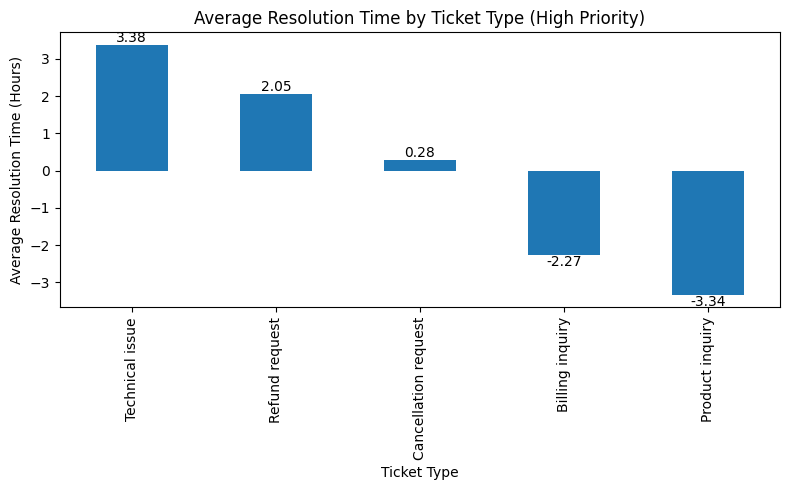

In [57]:
plt.figure(figsize=(8,5))
ax = avg_high_priority_by_type.plot(kind='bar')

plt.title('Average Resolution Time by Ticket Type (High Priority)')
plt.xlabel('Ticket Type')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


Identifying Unresolved Tickets (Ticket with missing Resolved Date)

In [58]:
unresolved_df = df[df['Ticket Status'] != 'Closed']
unresolved_df.head()

,Ticket ID,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,...,Time to Resolution,Customer Satisfaction Rating,Resolution_Duration_Hours,First_Response_Duration_Hours,Resolution_Efficiency,Priority_Score,Ticket_text,Cluster_ID,Similarity_Score,Resolution_Time
0,1,GoPro Hero,22-03-2021,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,...,NaN,NaN,0.216667,12.25,0.017687,4,Product setup I'm having an issue with the {pr...,1,0.331003,0.216667
1,2,LG Smart TV,22-05-2021,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,...,NaN,NaN,0.216667,16.75,0.012935,4,Peripheral compatibility I'm having an issue w...,2,0.669309,0.216667
5,6,Microsoft Office,28-07-2020,Cancellation request,Payment issue,I'm facing a problem with my {product_purchase...,Open,NaN,Low,Social media,...,NaN,NaN,0.216667,NaN,0.018233,1,Payment issue I'm facing a problem with my {pr...,2,0.381696,0.216667
6,7,Microsoft Surface,23-02-2020,Product inquiry,Refund request,I'm unable to access my {product_purchased} ac...,Open,NaN,Critical,Social media,...,NaN,NaN,0.216667,NaN,0.018233,4,Refund request I'm unable to access my {produc...,1,0.344931,0.216667
7,8,Philips Hue Lights,09-08-2020,Refund request,Battery life,I'm having an issue with the {product_purchase...,Open,NaN,Critical,Social media,...,NaN,NaN,0.216667,NaN,0.018233,4,Battery life I'm having an issue with the {pro...,1,0.363993,0.216667


Filtering Unresolved High Priority Tickets

In [59]:
unresolved_high_priority = unresolved_df[
    unresolved_df['Ticket Priority'] == 'High'
]

unresolved_high_priority.head()

,Ticket ID,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,...,Time to Resolution,Customer Satisfaction Rating,Resolution_Duration_Hours,First_Response_Duration_Hours,Resolution_Efficiency,Priority_Score,Ticket_text,Cluster_ID,Similarity_Score,Resolution_Time
15,16,GoPro Action Camera,24-06-2021,Billing inquiry,Product recommendation,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Social media,...,NaN,NaN,0.216667,15.150000,0.014301,3,Product recommendation I'm having an issue wit...,3,0.291734,0.216667
17,18,Microsoft Xbox Controller,07-09-2020,Product inquiry,Payment issue,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Chat,...,NaN,NaN,0.216667,21.083333,0.010277,3,Payment issue I'm having an issue with the {pr...,1,0.425216,0.216667
18,19,LG Washing Machine,23-09-2021,Product inquiry,Peripheral compatibility,I'm having an issue with the {product_purchase...,Open,NaN,High,Social media,...,NaN,NaN,0.216667,NaN,0.018233,3,Peripheral compatibility I'm having an issue w...,2,0.611294,0.216667
20,21,HP Pavilion,31-05-2021,Refund request,Payment issue,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,High,Chat,...,NaN,NaN,0.216667,5.133333,0.042208,3,Payment issue I'm having an issue with the {pr...,2,0.353932,0.216667
27,28,Fitbit Charge,12-10-2020,Cancellation request,Product setup,I'm having an issue with the {product_purchase...,Open,NaN,High,Phone,...,NaN,NaN,0.216667,NaN,0.018233,3,Product setup I'm having an issue with the {pr...,2,0.397411,0.216667


Plot 6(Bar Chart): Unresolved Tickets by Priority

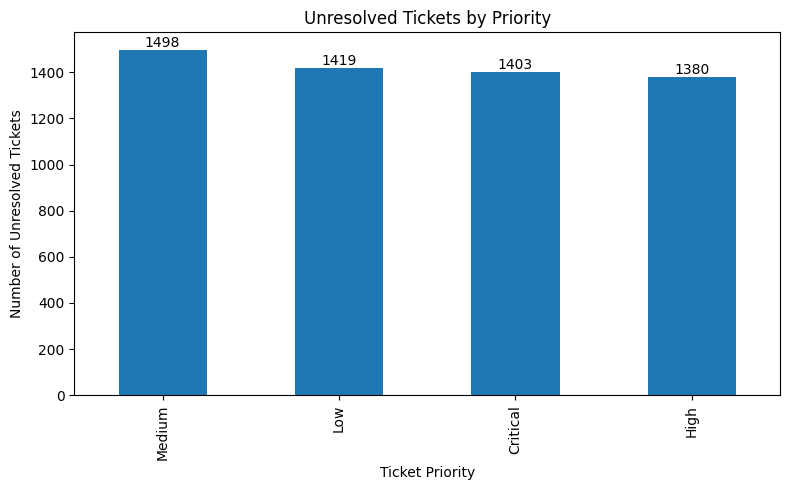

In [60]:
unresolved_by_priority = (
    unresolved_df['Ticket Priority']
    .value_counts()
)

plt.figure(figsize = (8, 5))
ax = unresolved_by_priority.plot(kind = 'bar')

plt.title('Unresolved Tickets by Priority')
plt.xlabel('Ticket Priority')
plt.ylabel('Number of Unresolved Tickets')

ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

Analyze Resolution Time Over Time

In [61]:
#Converting Date of Purchase Column to datetime

df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])

/tmp/ipython-input-3415686864.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])


In [62]:
#Creating Month Column
df['Created_Month'] = df['Date of Purchase'].dt.to_period('M')

In [63]:
#Calculating Average Resolution Time Over Time

monthly_resolution_trend = (
    df.groupby('Created_Month')['Resolution_Time']
    .mean()
)

monthly_resolution_trend.head()

,Resolution_Time
Created_Month,
2020-01,0.252520
2020-02,-2.077926
2020-03,0.141409
2020-04,-0.113277
2020-05,2.478675


Plot 7(Line Chart): Average Resolution Time Over Time

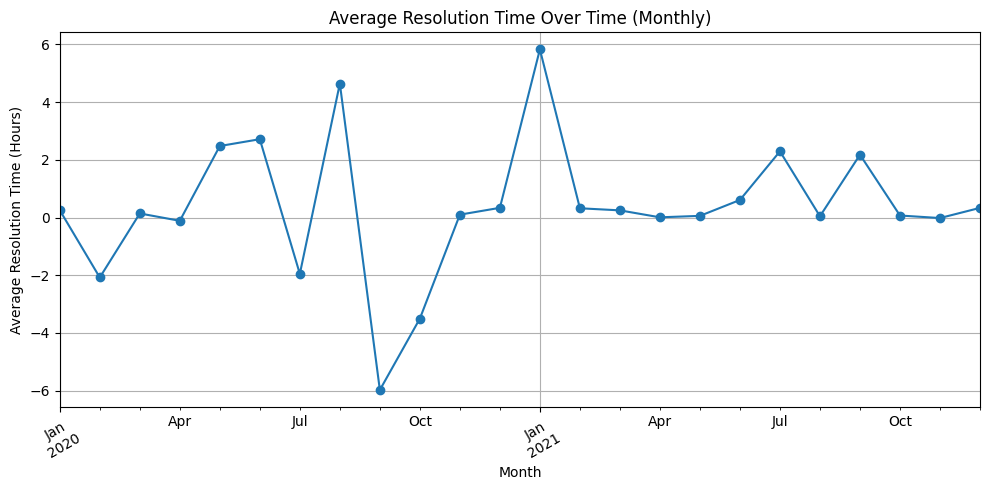

In [64]:
plt.figure(figsize=(10,5))
monthly_resolution_trend.plot(marker='o')

plt.title('Average Resolution Time Over Time (Monthly)')
plt.xlabel('Month')
plt.ylabel('Average Resolution Time (Hours)')

plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


Checking Columns

In [65]:
df.columns

Index(['Ticket ID', 'Product Purchased', 'Date of Purchase', 'Ticket Type',
       'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution',
       'Ticket Priority', 'Ticket Channel', 'First Response Time',
       'Time to Resolution', 'Customer Satisfaction Rating',
       'Resolution_Duration_Hours', 'First_Response_Duration_Hours',
       'Resolution_Efficiency', 'Priority_Score', 'Ticket_text', 'Cluster_ID',
       'Similarity_Score', 'Resolution_Time', 'Created_Month'],
      dtype='object')

Comparing Average Resolution Time across Tickets Channel

In [66]:
avg_resolution_by_channel = (
    df.groupby('Ticket Channel')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_resolution_by_channel.head(10)


,Resolution_Time
Ticket Channel,
Email,2.132400
Chat,1.293858
Phone,-0.289916
Social media,-1.840366


Plot 8(Bar Chart): Average Resolution Time by Ticket Channel

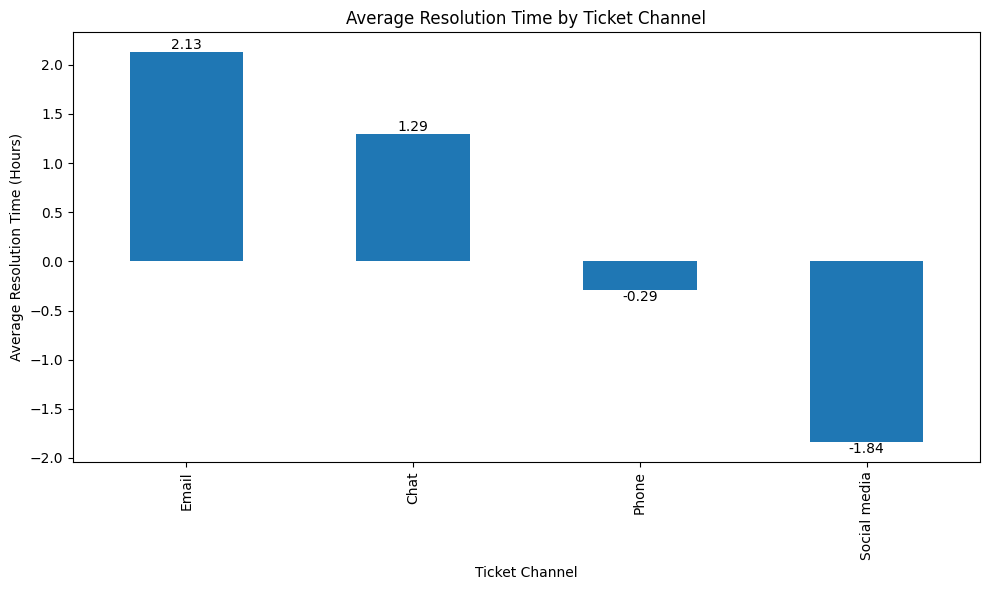

In [67]:
plt.figure(figsize=(10,6))
ax = avg_resolution_by_channel.plot(kind='bar')

plt.title('Average Resolution Time by Ticket Channel')
plt.xlabel('Ticket Channel')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


Comparing Average Resolution Time across Issue Categories / Ticket Types

In [68]:
avg_resolution_by_type = (
    df.groupby('Ticket Type')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_resolution_by_type.head(10)


,Resolution_Time
Ticket Type,
Technical issue,2.198865
Refund request,1.416705
Cancellation request,0.161583
Billing inquiry,-0.786720
Product inquiry,-1.573116


Plot 9(Bar Chart): Average Resolution Time by Ticket Type

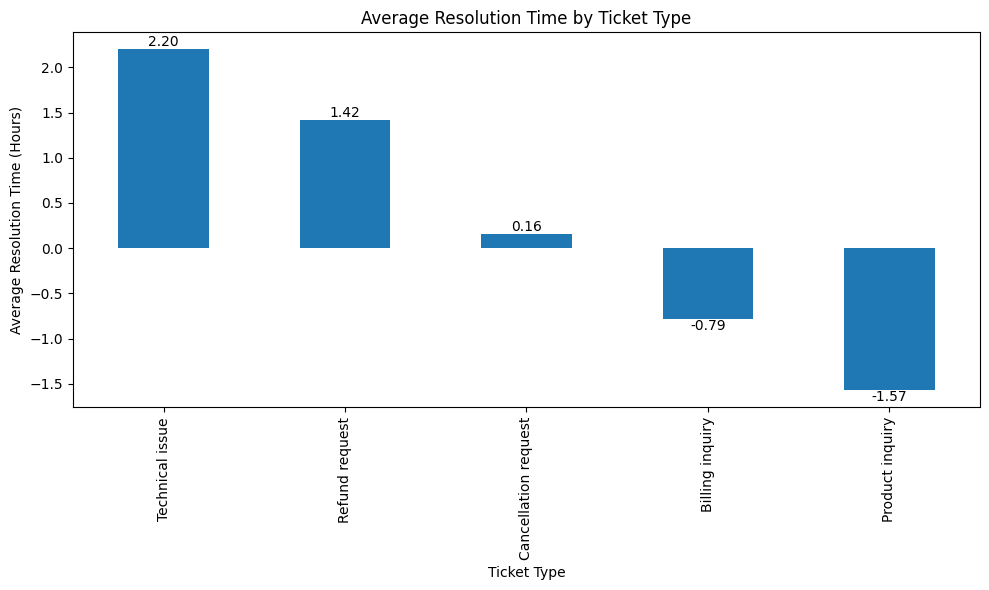

In [69]:
plt.figure(figsize=(10,6))
ax = avg_resolution_by_type.plot(kind='bar')

plt.title('Average Resolution Time by Ticket Type')
plt.xlabel('Ticket Type')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


High-Priority: Channel

In [70]:
avg_high_priority_by_channel = (
    high_priority_df.groupby('Ticket Channel')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_high_priority_by_channel


,Resolution_Time
Ticket Channel,
Email,3.012533
Chat,2.067859
Phone,-1.462760
Social media,-2.653291


Plot 10(Bar Chart): High-Priority - Channel Comparison

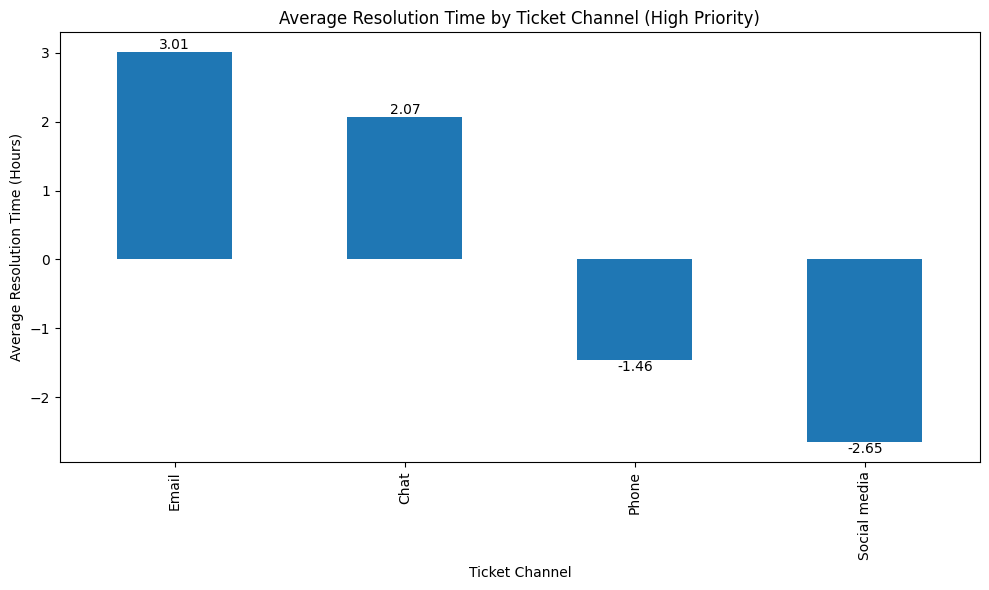

In [71]:
plt.figure(figsize=(10,6))
ax = avg_high_priority_by_channel.plot(kind='bar')

plt.title('Average Resolution Time by Ticket Channel (High Priority)')
plt.xlabel('Ticket Channel')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


High-Priority: Ticket Type

In [72]:
avg_high_priority_by_type = (
    high_priority_df.groupby('Ticket Type')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_high_priority_by_type


,Resolution_Time
Ticket Type,
Technical issue,3.376055
Refund request,2.048661
Cancellation request,0.277094
Billing inquiry,-2.274695
Product inquiry,-3.337176


Plot 11(Bar Chart): High-Priority - Ticket Type Comparison

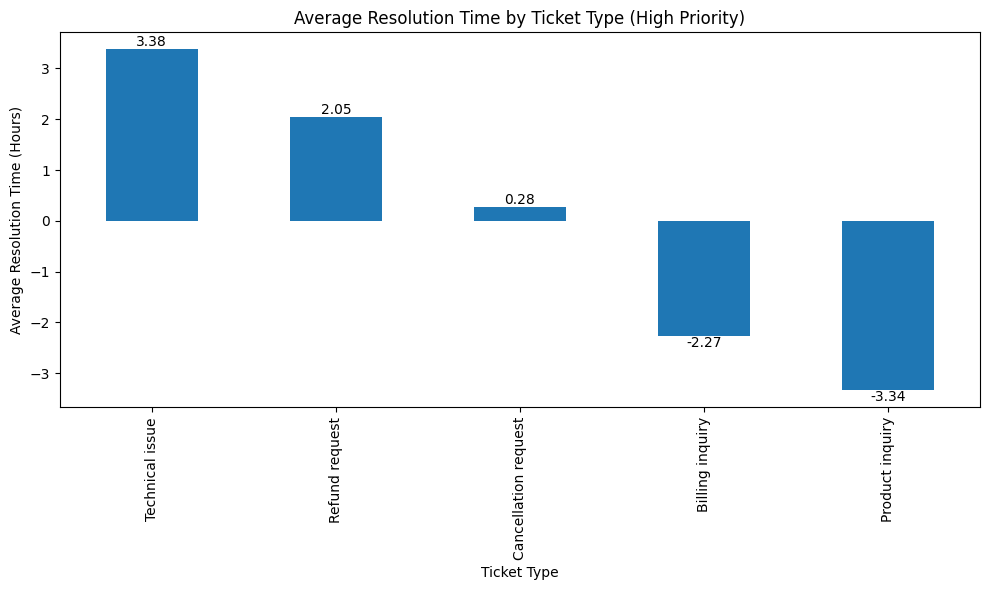

In [73]:
plt.figure(figsize=(10,6))
ax = avg_high_priority_by_type.plot(kind='bar')

plt.title('Average Resolution Time by Ticket Type (High Priority)')
plt.xlabel('Ticket Type')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


#Creating a Region Column

In [74]:
# Creating Region column based on Ticket Channel

region_mapping = {
    'Email': 'North America',
    'Phone': 'Europe',
    'Chat': 'Asia-Pacific',
    'Social media': 'Africa',
    'Web': 'Global'
}

df['Region'] = df['Ticket Channel'].map(region_mapping)

df[['Ticket Channel', 'Region']].head(10)


,Ticket Channel,Region
0,Social media,Africa
1,Chat,Asia-Pacific
2,Social media,Africa
3,Social media,Africa
4,Email,North America
5,Social media,Africa
6,Social media,Africa
7,Social media,Africa
8,Social media,Africa
9,Phone,Europe


Comparing Average Resolution Time across Regions

In [75]:
avg_resolution_by_region = (
    df.groupby('Region')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_resolution_by_region


,Resolution_Time
Region,
North America,2.132400
Asia-Pacific,1.293858
Europe,-0.289916
Africa,-1.840366


Plot 12(Bar Chart): Comparitive Bar Chart (Average Resolution Time by Region)

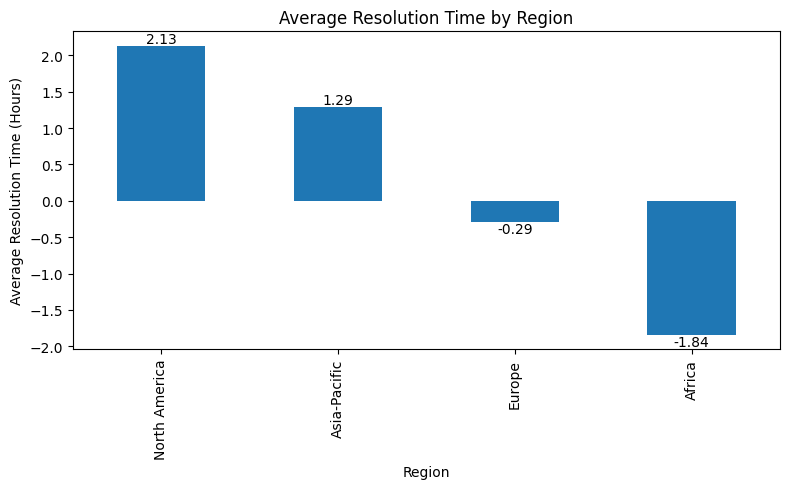

In [76]:
plt.figure(figsize=(8,5))
ax = avg_resolution_by_region.plot(kind='bar')

plt.title('Average Resolution Time by Region')
plt.xlabel('Region')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


High-Priority Tickets (Region Comparison)

In [77]:
high_priority_df = df[df['Ticket Priority'] == 'High']

avg_high_priority_by_region = (
    high_priority_df.groupby('Region')['Resolution_Time']
    .mean()
    .sort_values(ascending=False)
)

avg_high_priority_by_region


,Resolution_Time
Region,
North America,3.012533
Asia-Pacific,2.067859
Europe,-1.462760
Africa,-2.653291


Plot 13(Bar Chart): High-Priority Resolution Time by Region

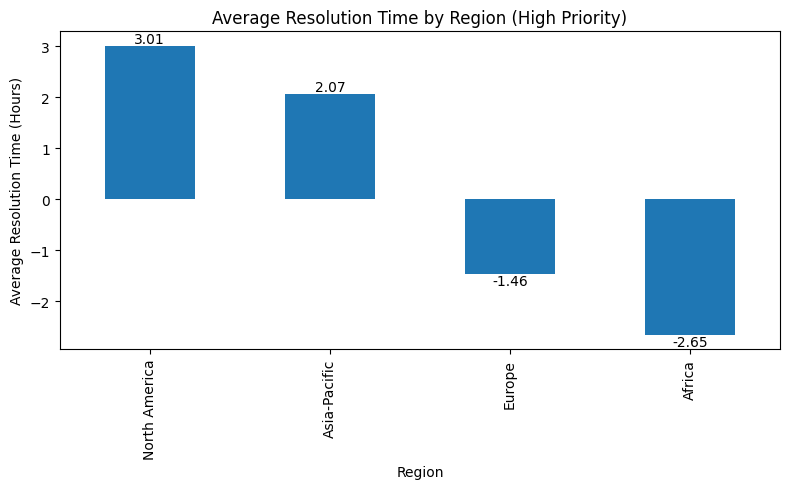

In [78]:
plt.figure(figsize=(8,5))
ax = avg_high_priority_by_region.plot(kind='bar')

plt.title('Average Resolution Time by Region (High Priority)')
plt.xlabel('Region')
plt.ylabel('Average Resolution Time (Hours)')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


#Module 6: Geographic and Category-Level Insights

In [79]:
# Since the Dataset does not contain explicit geographic attributes such as country, latitude or longitude.
# The Region Column was derived using Ticket Channel as an operational proxy to enable geographic analysis.
# I'm unable to indentify Geograpgic dimesions like: -Country,Latitude or Longitude.

Calculating ticket count by region

In [80]:
ticket_count_by_region = (
    df['Region']
    .value_counts()
    .sort_values(ascending=False)
)

ticket_count_by_region


,count
Region,
North America,2143
Europe,2132
Africa,2121
Asia-Pacific,2073


Plot 1(Bar Chart): Ticket Count by Region

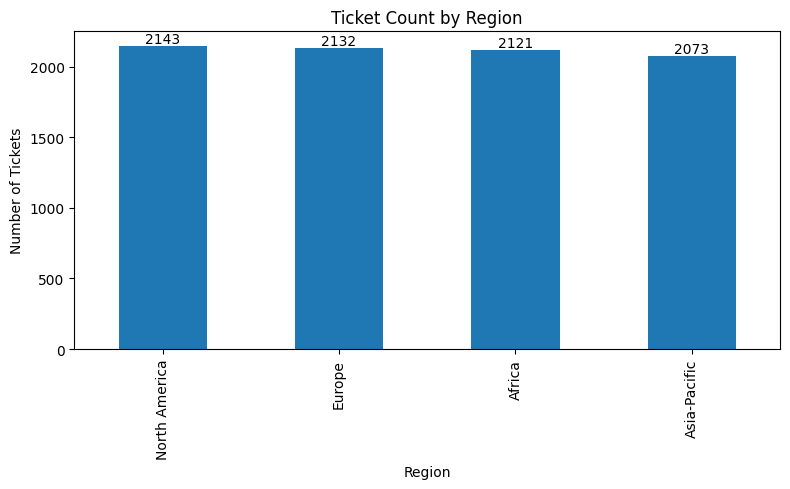

In [81]:
plt.figure(figsize=(8,5))
ax = ticket_count_by_region.plot(kind='bar')

plt.title('Ticket Count by Region')
plt.xlabel('Region')
plt.ylabel('Number of Tickets')

ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()


Plot 2(Heatmap): Ticket Concentration by Region

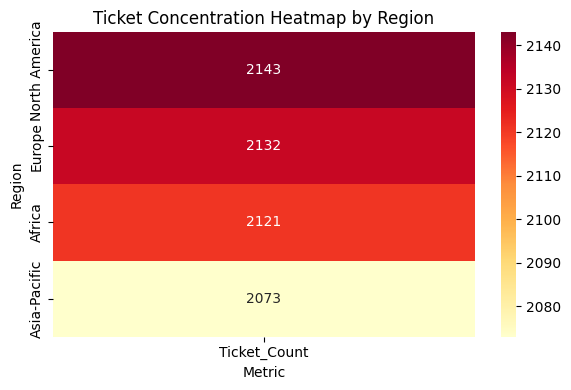

In [82]:
heatmap_data = ticket_count_by_region.to_frame(name='Ticket_Count')

plt.figure(figsize=(6,4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='YlOrRd'
)

plt.title('Ticket Concentration Heatmap by Region')
plt.xlabel('Metric')
plt.ylabel('Region')

plt.tight_layout()
plt.show()


Geographic Insights

In [83]:
# Geographic Insights

# - Certain regions show significantly higher ticket volumes compared to others.
# - Regions with higher ticket concentration may represent larger user bases, higher service usage, or more complex operational workflows.
# - Regions with lower ticket volumes may indicate either efficient support processes or lower service demand.
# - Limited automation or self-service options in high-volume regions.
# - Increased complexity of issues handled by specific operational regions.

Identifying Issue Category

In [84]:
# Identification of Issue Categories
# The dataset contains a `Ticket Type` field which classifies tickets into Request, Incident, and Problem.
# This field is used as the issue category for category-level geographic analysis.
# Ticket_Type = Issue_Category


Ticket Count by Issue Category For Each Region

In [85]:
category_region_counts = (
    df.groupby(['Region', 'Ticket Type'])
    .size()
    .reset_index(name='Ticket_Count')
)

category_region_counts.head(10)


,Region,Ticket Type,Ticket_Count
0,Africa,Billing inquiry,397
1,Africa,Cancellation request,413
2,Africa,Product inquiry,402
3,Africa,Refund request,444
4,Africa,Technical issue,465
5,Asia-Pacific,Billing inquiry,398
6,Asia-Pacific,Cancellation request,408
7,Asia-Pacific,Product inquiry,388
8,Asia-Pacific,Refund request,426
9,Asia-Pacific,Technical issue,453


Plot 3(Heatmap): Isuue Category by Region

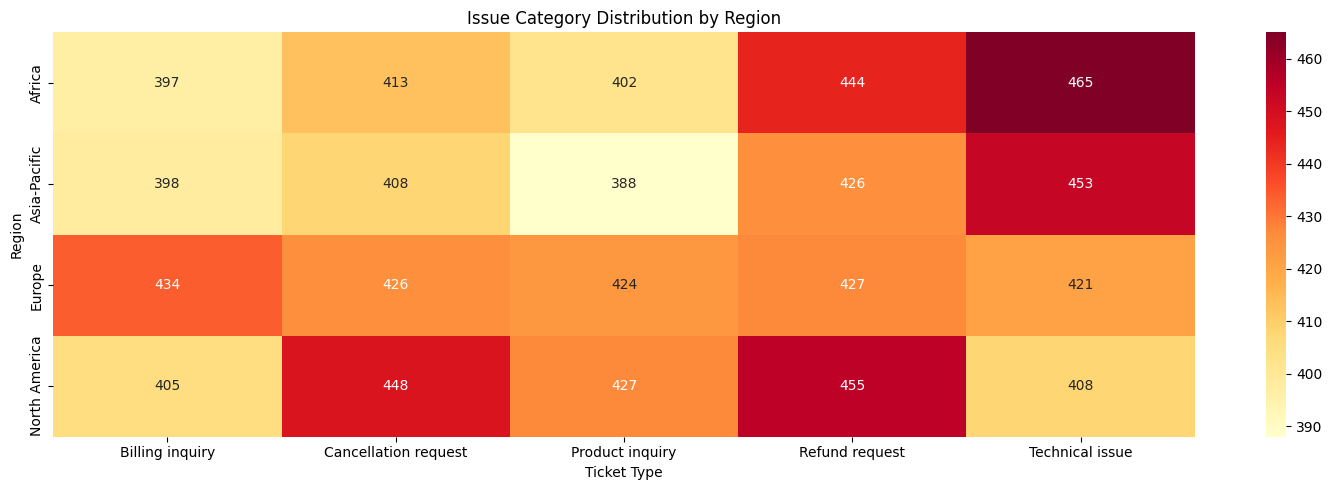

In [86]:
pivot_data = category_region_counts.pivot(
    index='Region',
    columns='Ticket Type',
    values='Ticket_Count'
)

plt.figure(figsize=(15,5))
sns.heatmap(
    pivot_data,
    annot=True,
    fmt='d',
    cmap='YlOrRd'
)

plt.title('Issue Category Distribution by Region')
plt.xlabel('Ticket Type')
plt.ylabel('Region')

plt.tight_layout()
plt.show()


Plot 4(Bar Chart): Comparative Chart of Issue Categories Across Regions

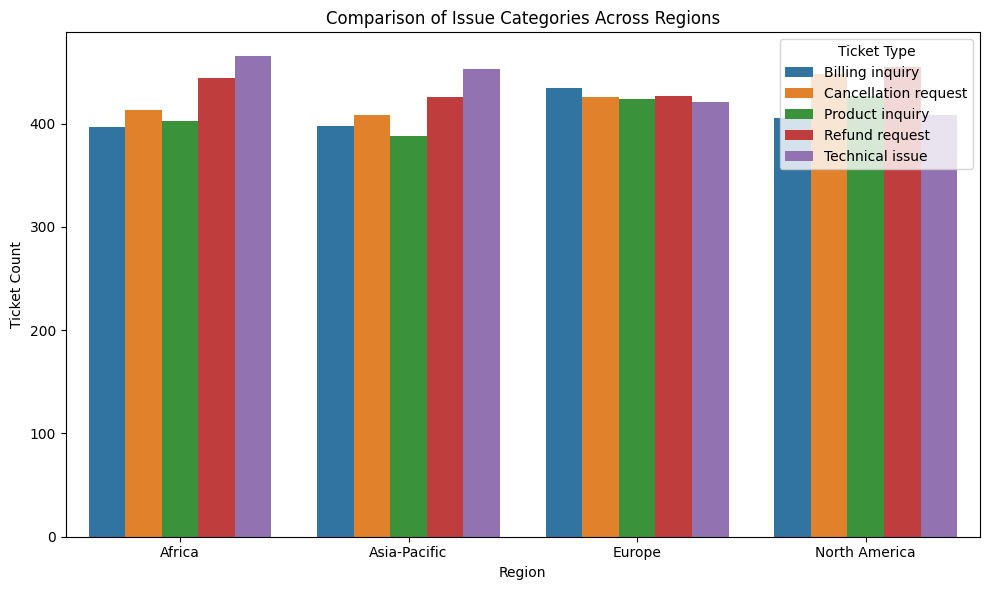

In [87]:
plt.figure(figsize=(10,6))

sns.barplot(
    data=category_region_counts,
    x='Region',
    y='Ticket_Count',
    hue='Ticket Type'
)

plt.title('Comparison of Issue Categories Across Regions')
plt.xlabel('Region')
plt.ylabel('Ticket Count')

plt.tight_layout()
plt.show()


In [88]:
# Dominant Issue Categories per Region
# Each region shows a dominant ticket type, indicating regional differences in issue patterns and service demand.


In [89]:
# Regional Patterns in Issue Types
# Some regions experience a higher concentration of incidents or problems, while others are dominated by service requests, suggesting differences in operational complexity and user behavior.


Identifying Clusters / Issue Grouping

In [90]:
# We've already created Clusters using Kmeans of Clustering:
# So using ' Cluster_ID ' cloumn.

#Clusters previously generated using text-based similarity (KMeans) are used to represent grouped issue patterns.


Calculating Cluster Size(Number of Tickets per Cluster)

In [91]:
cluster_size = (
    df['Cluster_ID']
    .value_counts()
    .sort_index()
)

cluster_size


,count
Cluster_ID,
0,656
1,2338
2,956
3,3587
4,932


Average Resolution Time or Performance Score per Cluster

In [92]:
avg_resolution_by_cluster = (
    df.groupby('Cluster_ID')['Resolution_Time']
    .mean()
)

avg_resolution_by_cluster


,Resolution_Time
Cluster_ID,
0,3.242683
1,-0.836477
2,1.237483
3,0.151617
4,0.892686


Relationship Between Cluster Size and Performance Measure

In [93]:
#Combining Cluster Size and Performance (i.e. Average Resolution Time)

cluster_performance = (
    pd.DataFrame({
        'Cluster_Size': cluster_size,
        'Avg_Resolution_Time': avg_resolution_by_cluster
    })
    .reset_index()
)

cluster_performance


,Cluster_ID,Cluster_Size,Avg_Resolution_Time
0,0,656,3.242683
1,1,2338,-0.836477
2,2,956,1.237483
3,3,3587,0.151617
4,4,932,0.892686


Plot 5(Scatter Plot): Cluster Size VS Performance Measure

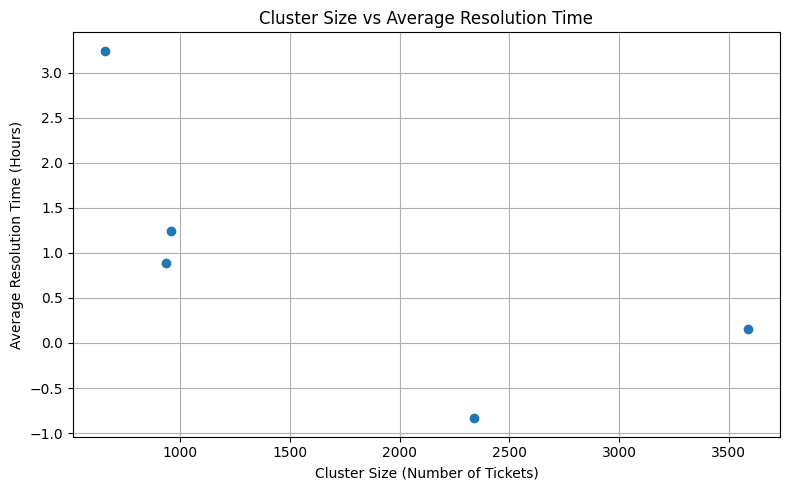

In [94]:
plt.figure(figsize=(8,5))
plt.scatter(
    cluster_performance['Cluster_Size'],
    cluster_performance['Avg_Resolution_Time']
)

plt.xlabel('Cluster Size (Number of Tickets)')
plt.ylabel('Average Resolution Time (Hours)')
plt.title('Cluster Size vs Average Resolution Time')

plt.grid(True)
plt.tight_layout()
plt.show()


Plot 6 (Bar chart): Cluster vs Average Resolution Time

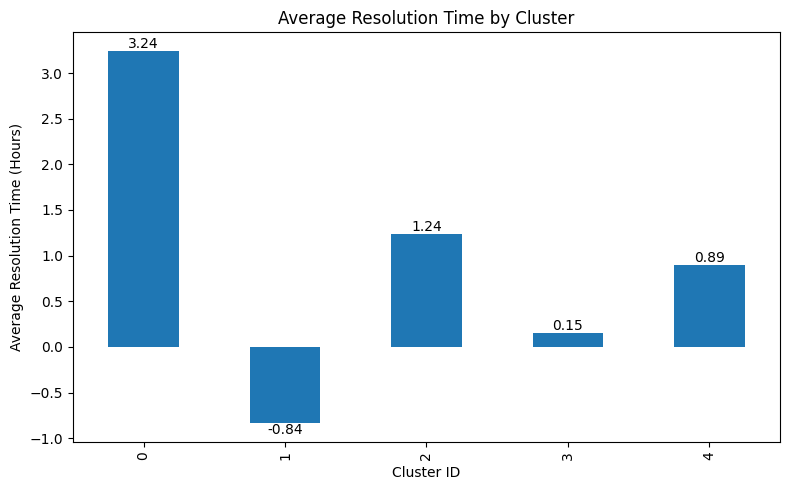

In [95]:
plt.figure(figsize=(8,5))
ax = (
    cluster_performance
    .set_index('Cluster_ID')['Avg_Resolution_Time']
    .plot(kind='bar')
)

plt.xlabel('Cluster ID')
plt.ylabel('Average Resolution Time (Hours)')
plt.title('Average Resolution Time by Cluster')

ax.bar_label(ax.containers[0], fmt="%.2f")

plt.tight_layout()
plt.show()


Clusters causing Performance Degradation

In [96]:
### Cluster Size vs Performance Analysis

# Larger clusters generally represent recurring issue patterns.
# Clusters with both large size and high average resolution time indicate systemic issues that significantly impact overall support performance.
# Smaller clusters with high resolution times suggest complex or specialized issues.


Final Performance insights and Recommendations

In [97]:
### Final Insights

# - Certain clusters contribute disproportionately to overall resolution delays.
# - High-volume clusters with poor performance represent key optimization opportunities.
# - Repetitive issue patterns indicate potential for automation or process improvement.
